In [19]:
# Importation des bibliothèques 
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Téléchargement des ressources
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Benjamin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Benjamin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# Chargement du dataset
data = pd.read_csv('data.csv')

# Suppression des lignes sans synopsis ou genres
data.dropna(subset=['overview', 'genre'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Filtrage des données (on garde seulement les colonnes qui nous intéressent)
sorted_data = data[['original_title', 'overview', 'genre']]
filtered_data = sorted_data[sorted_data['overview'].str.len() > 10]

In [21]:
# Tokenisation et lemmatisation avec NLTK
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    print("Tokens avant lemmatisation :", tokens)
    print("Tokens après lemmatisation :", lemmatized_tokens)
    return lemmatized_tokens

In [22]:
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(filtered_data['overview'], filtered_data['genre'], test_size=0.2, random_state=42)

In [23]:
# Entraîner le modèle Word2Vec seulement sur l'ensemble d'entraînement
train_tokens = X_train.apply(preprocess_text)
model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

Tokens avant lemmatisation : ['A', 'car', 'accident', 'and', 'shifting', 'affections', 'test', 'the', 'bond', 'between', 'a', 'married', 'couple', '.']
Tokens après lemmatisation : ['a', 'car', 'accident', 'and', 'shifting', 'affection', 'test', 'the', 'bond', 'between', 'a', 'married', 'couple', '.']
Tokens avant lemmatisation : ['Ever', 'since', 'the', 'second', 'grade', 'when', 'he', 'first', 'saw', 'her', 'in', 'E.T', '.', 'The', 'Extraterrestrial', ',', 'Brian', 'Herzlinger', 'has', 'had', 'a', 'crush', 'on', 'Drew', 'Barrymore', '.', 'Now', ',', '20', 'years', 'later', 'he', "'s", 'decided', 'to', 'try', 'to', 'fulfill', 'his', 'lifelong', 'dream', 'by', 'asking', 'her', 'for', 'a', 'date', '.', 'There', "'s", 'one', 'small', 'problem', ':', 'She', "'s", 'Drew', 'Barrymore', 'and', 'he', "'s", ',', 'well', ',', 'Brian', 'Herzlinger', ',', 'a', 'broke', '27-year-old', 'aspiring', 'filmmaker', 'from', 'New', 'Jersey', '.']
Tokens après lemmatisation : ['ever', 'since', 'the', 'seco

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [24]:
# Transformer les données d'entraînement et de test en embeddings
X_train_embeddings = np.array([np.mean([model.wv[word] for word in doc if word in model.wv] or [np.zeros(model.vector_size)], axis=0) for doc in train_tokens])
X_test_embeddings = np.array([np.mean([model.wv[word] for word in doc if word in model.wv] or [np.zeros(model.vector_size)], axis=0) for doc in X_test.apply(preprocess_text)])

Tokens avant lemmatisation : ['A', 'baseball', 'legend', 'almost', 'finished', 'with', 'his', 'distinguished', 'career', 'at', 'the', 'age', 'of', 'forty', 'has', 'one', 'last', 'chance', 'to', 'prove', 'who', 'he', 'is', ',', 'what', 'he', 'is', 'capable', 'of', ',', 'and', 'win', 'the', 'heart', 'of', 'the', 'woman', 'he', 'has', 'loved', 'for', 'the', 'past', 'four', 'years', '.']
Tokens après lemmatisation : ['a', 'baseball', 'legend', 'almost', 'finished', 'with', 'his', 'distinguished', 'career', 'at', 'the', 'age', 'of', 'forty', 'ha', 'one', 'last', 'chance', 'to', 'prove', 'who', 'he', 'is', ',', 'what', 'he', 'is', 'capable', 'of', ',', 'and', 'win', 'the', 'heart', 'of', 'the', 'woman', 'he', 'ha', 'loved', 'for', 'the', 'past', 'four', 'year', '.']
Tokens avant lemmatisation : ['There', "'s", 'a', 'deadly', 'zombie', 'epidemic', 'threatening', 'humanity', ',', 'but', 'Wade', ',', 'a', 'small-town', 'farmer', 'and', 'family', 'man', ',', 'refuses', 'to', 'accept', 'defeat', 

In [28]:
# Entraîner le modèle de classification sur l'ensemble d'entraînement
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_embeddings, y_train)

# Genres prédits pour les 10 premiers films
print("Genres prédits pour les 10 premiers films de (ensemble d'entraînement) :", clf.predict(X_train_embeddings)[:10])

# Genres réels pour les 10 premiers films
print("Genres réels pour les 10 premiers films de (ensemble d'entraînement) :", y_train[:10].values)

Genres prédits pour les 10 premiers films de (ensemble d'entraînement) : ['Drama' 'Documentary' 'Western' 'Drama' 'Action' 'Comedy' 'Adventure'
 'Thriller' 'Comedy' 'Comedy']
Genres réels pour les 10 premiers films de (ensemble d'entraînement) : ['Drama' 'Documentary' 'Western' 'Drama' 'Action' 'Comedy' 'Adventure'
 'Thriller' 'Comedy' 'Comedy']


In [29]:
# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test_embeddings)

# Afficher les genres prédits pour les 10 premiers films
print("Genres prédits pour les 10 premiers films de (ensemble de test) :", y_pred[:10])

# Afficher les genres réels pour les 10 premiers films 
print("Genres réels pour les 10 premiers films de (ensemble de test) :", y_test[:10].values)

Genres prédits pour les 10 premiers films de (ensemble de test) : ['Drama' 'Comedy' 'Drama' 'Action' 'Drama' 'Comedy' 'Drama' 'Comedy'
 'Drama' 'Comedy']
Genres réels pour les 10 premiers films de (ensemble de test) : ['Drama' 'Horror' 'Comedy' 'Action' 'Comedy' 'Drama' 'Horror' 'Fantasy'
 'Drama' 'Science Fiction']


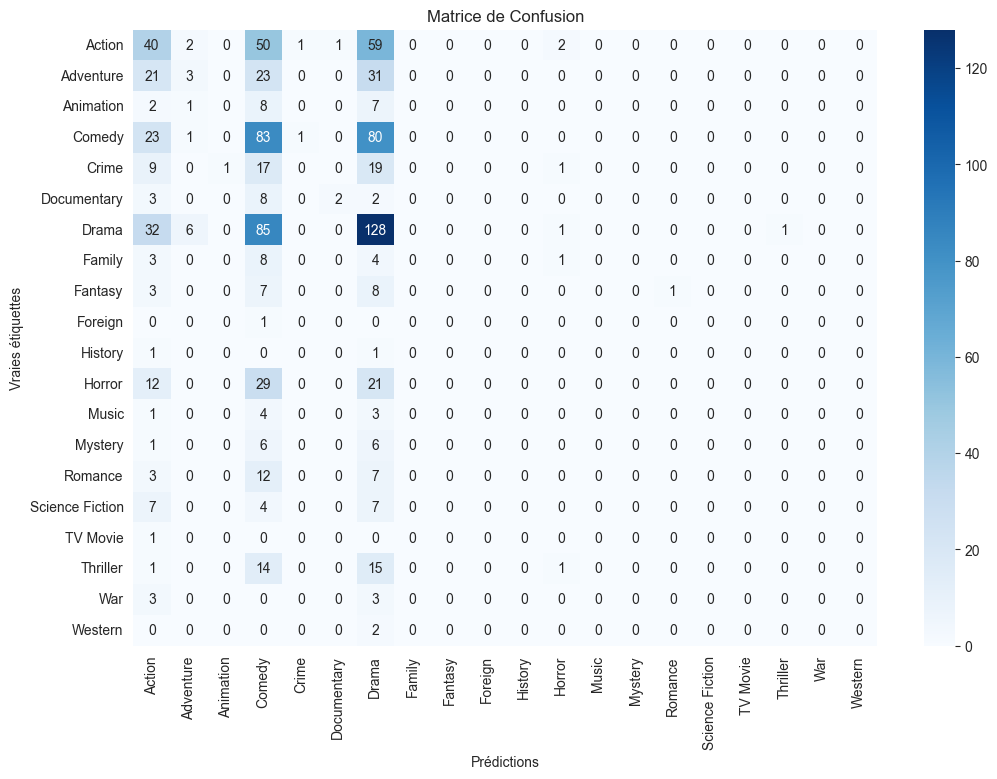

In [31]:
# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

In [32]:
# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :\n", class_report)

Rapport de classification :
                  precision    recall  f1-score   support

         Action       0.24      0.26      0.25       155
      Adventure       0.23      0.04      0.07        78
      Animation       0.00      0.00      0.00        18
         Comedy       0.23      0.44      0.30       188
          Crime       0.00      0.00      0.00        47
    Documentary       0.67      0.13      0.22        15
          Drama       0.32      0.51      0.39       253
         Family       0.00      0.00      0.00        16
        Fantasy       0.00      0.00      0.00        19
        Foreign       0.00      0.00      0.00         1
        History       0.00      0.00      0.00         2
         Horror       0.00      0.00      0.00        62
          Music       0.00      0.00      0.00         8
        Mystery       0.00      0.00      0.00        13
        Romance       0.00      0.00      0.00        22
Science Fiction       0.00      0.00      0.00        18
 

C:\Users\Benjamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Benjamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Benjamin\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [36]:
# Faire des prédictions sur de nouvelles données
new_data = ["A spaceship travels to distant galaxies.", "A romantic drama set in Paris."]
processed_new_data = [preprocess_text(text) for text in new_data]
X_new = np.array([np.mean([model.wv[word] for word in doc if word in model.wv] or [np.zeros(model.vector_size)], axis=0) for doc in processed_new_data])

Tokens avant lemmatisation : ['A', 'spaceship', 'travels', 'to', 'distant', 'galaxies', '.']
Tokens après lemmatisation : ['a', 'spaceship', 'travel', 'to', 'distant', 'galaxy', '.']
Tokens avant lemmatisation : ['A', 'romantic', 'drama', 'set', 'in', 'Paris', '.']
Tokens après lemmatisation : ['a', 'romantic', 'drama', 'set', 'in', 'paris', '.']


In [42]:
# Prédire les genres des nouvelles données
predicted_genres = clf.predict(X_new)
print("Genres prédits pour les nouvelles données :", predicted_genres)

Genres prédits pour les nouvelles données : ['Comedy' 'Comedy']
